In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import mean_absolute_error, mean_squared_error

# import warnings
# warnings.filterwarnings('ignore')

# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.layers import GRU, Dense
# from tensorflow.keras.models import Sequential, ModuleNotFoundError
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.losses import MeanSquaredError
# from tensorflow.keras.metrics import MeanAbsoluteError

# from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

In [6]:
df = pd.read_csv('daily_weather.csv')

In [7]:
df.head(10)

,date,temperature
0,01/01/2009,-6.810629
1,02/01/2009,-3.360486
2,03/01/2009,5.435694
3,04/01/2009,7.283889
4,05/01/2009,12.690069
5,06/01/2009,15.201597
6,07/01/2009,20.121875
7,08/01/2009,18.864792
8,09/01/2009,21.289722
9,10/01/2009,11.937847


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2923 entries, 0 to 2922
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         2923 non-null   object 
 1   temperature  2921 non-null   float64
dtypes: float64(1), object(1)
memory usage: 45.8+ KB


In [9]:
# we will fill the missing values using forward fill
df = df.ffill()
df['date'] = pd.to_datetime(df['date'], format="%d/%m/%Y")
df = df.set_index('date')
df.index.freq = 'D'

<Axes: xlabel='date'>

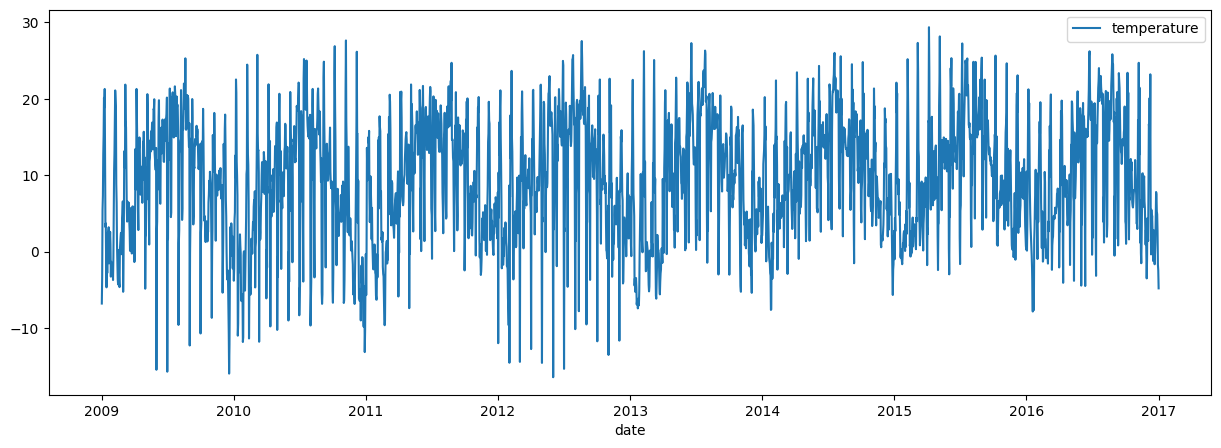

In [10]:
plt.figure(figsize=(15,5))
sns.lineplot(data=df)

In [11]:
def slideWindow(df, window_in, horizon):
    d = df.values
    X, y = [], []
    idx = df.index[:-window_in]

    for start in range(len(df)-window_in):
        end = start + window_in
        out = end + horizon
        X.append(d[start:end].reshape(-1))
        y.append(d[end:out].ravel())
    
    cols_x = [f'x{i}' for i in range(1, window_in+1)]
    cols_y = [f'y{i}' for i in range(1, horizon+1)]
    df_xs = pd.DataFrame(X, index=idx, columns=cols_x)
    df_y = pd.DataFrame(y, index=idx, columns=cols_y)
    return pd.concat([df_xs, df_y], axis=1).dropna()

In [12]:
val_ind = "2013-01-01"
test_ind = '2015-01-01'

train = df.copy()[df.index < val_ind]
valid = df.copy()[(df.index >= val_ind) & (df.index < test_ind)]
test = df.copy()[df.index >= test_ind]
train.shape, valid.shape, test.shape

((1461, 1), (730, 1), (732, 1))

In [13]:
# Scale data to be in range (0, 1)
scaler = MinMaxScaler()
train['temperature'] = scaler.fit_transform(train)

valid['temperature'] = scaler.transform(valid)
test['temperature'] = scaler.transform(test)

## Prediction one-step ahead

In [14]:
# shift data to create the input samples
win_in = 6
horizon = 1

train_shift = slideWindow(train, win_in, horizon)
valid_shift = slideWindow(valid, win_in, horizon)
test_shift = slideWindow(test, win_in, horizon)

train_shift.head()

,x1,x2,x3,x4,x5,x6,y1
date,,,,,,,
2009-01-01,0.218753,0.296990,0.496457,0.538367,0.660961,0.717914,0.829488
2009-01-02,0.296990,0.496457,0.538367,0.660961,0.717914,0.829488,0.800982
2009-01-03,0.496457,0.538367,0.660961,0.717914,0.829488,0.800982,0.855971
2009-01-04,0.538367,0.660961,0.717914,0.829488,0.800982,0.855971,0.643903
2009-01-05,0.660961,0.717914,0.829488,0.800982,0.855971,0.643903,0.446006


In [16]:
# convert data to tensors
y_train = train_shift['y1'].to_numpy()
print(y_train.shape)

X_train = train_shift.iloc[:, :-1].to_numpy()
X_train = X_train.reshape(X_train.shape[0], win_in, 1)
print(X_train.shape)

y_valid = valid_shift['y1'].to_numpy()
print(y_valid.shape)

X_valid = valid_shift.iloc[:, :-1].to_numpy()
X_valid = X_valid.reshape(X_valid.shape[0], win_in, 1)
print(X_valid.shape)

y_test = test_shift['y1'].to_numpy()
print(y_test.shape)

(1455,)
(1455, 6, 1)
(724,)
(724, 6, 1)
(726,)


## GRU model to predict the next temperature day

In [ ]:
LATENT_DIM = 5
BATCH_SIZE = 32
EPOCHS = 50
PATIENCE = 5
HORIZON = 1

In [ ]:
gru_model = Sequential()
gru_model.add(GRU(LATENT_DIM, input_shape=(win_in, 1)))
gru_model.add(Dense(HORIZON))
gru_model.compile(optimizer='RMSprop', loss='mse', metrics=['mae'])
gru_model.summary()

In [ ]:
earlystop = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, min_delta=0)

history_lstm = gru_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_valid, y_valid), callbacks=[earlystop], verbose=1)
# lstm pred

In [ ]:
gru_ts_pred = gru_model.predict(X_test)

results = test_shift[['y1']].copy()
results['GRU_pred'] = gru_ts_pred
results[['y1', 'GRU_pred']] = scaler.inverse_transform(results[['y1', 'GRU_pred']])
print(results.shape)
results.head()

In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(LATENT_DIM, input_shape=(win_in, 1)))
lstm_model.add(Dense(HORIZON))

lstm_model.compile(optimizer='RMSprop', loss='mse', metrics=['mae'])
lstm_model.summary()

In [ ]:
#evaluate the results

## Multi-Step Forecast

In [ ]:
# it is the same but the horizon is 3